# 2. Data Understanding

#### 2.1 Load Data

In this step, we will load the dataset and the necessary libraries. We will also perform a first inspection of the data.

#### 2.0 Dataset Download

First, we'll automatically download the Sentiment140 dataset if it doesn't exist locally.

In [2]:
import os
import urllib.request
import zipfile
from pathlib import Path
from tqdm.auto import tqdm

# Dataset configuration
DATA_DIR = Path('../data')
DATASET_ZIP = DATA_DIR / 'training.1600000.processed.noemoticon.zip'
DATASET_CSV = DATA_DIR / 'training.1600000.processed.noemoticon.csv'
DATASET_URL = 'https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'

# Create data directory if it doesn't exist
DATA_DIR.mkdir(parents=True, exist_ok=True)

def download_with_progress(url, destination):
    """Download file with progress bar"""
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)
    
    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=destination.name) as t:
        urllib.request.urlretrieve(url, filename=destination, reporthook=t.update_to)

# Check if dataset already exists
if DATASET_CSV.exists():
    print(f"✓ Dataset already exists at {DATASET_CSV.absolute()}")
    print(f"  Size: {DATASET_CSV.stat().st_size / (1024**2):.1f} MB")
else:
    print("📥 Downloading Sentiment140 dataset...")
    print(f"   Source: {DATASET_URL}")
    print(f"   This may take a few minutes (file is ~80 MB compressed)...")
    
    try:
        # Download the zip file
        download_with_progress(DATASET_URL, DATASET_ZIP)
        print(f"✓ Download complete: {DATASET_ZIP.name}")
        
        # Extract the specific file we need
        print("📦 Extracting dataset...")
        with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
            # The zip contains: training.1600000.processed.noemoticon.csv and testdata.manual.2009.06.14.csv
            zip_ref.extract('training.1600000.processed.noemoticon.csv', DATA_DIR)
        
        print(f"✓ Extracted to {DATASET_CSV.absolute()}")
        print(f"  Size: {DATASET_CSV.stat().st_size / (1024**2):.1f} MB")
        
        # Clean up zip file
        DATASET_ZIP.unlink()
        print("✓ Cleaned up temporary files")
        
    except Exception as e:
        print(f"❌ ERROR during download/extraction: {e}")
        print("\nManual download instructions:")
        print("1. Visit: http://help.sentiment140.com/for-students")
        print("2. Download 'training.1600000.processed.noemoticon.csv'")
        print(f"3. Place it in: {DATA_DIR.absolute()}")
        raise

print("\n✅ Dataset ready for analysis!")

/Users/skress/Documents/DBU/Machine_Learning/Studienarbeit_Praxis/venv_Machine_Learning/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📥 Downloading Sentiment140 dataset...
   Source: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
   This may take a few minutes (file is ~80 MB compressed)...


training.1600000.processed.noemoticon.zip: 81.4MB [00:08, 9.58MB/s]                              



✓ Download complete: training.1600000.processed.noemoticon.zip
📦 Extracting dataset...
✓ Extracted to /Users/skress/Documents/DBU/Machine_Learning/Studienarbeit_Praxis/notebooks/../data/training.1600000.processed.noemoticon.csv
  Size: 227.7 MB
✓ Cleaned up temporary files

✅ Dataset ready for analysis!
✓ Extracted to /Users/skress/Documents/DBU/Machine_Learning/Studienarbeit_Praxis/notebooks/../data/training.1600000.processed.noemoticon.csv
  Size: 227.7 MB
✓ Cleaned up temporary files

✅ Dataset ready for analysis!


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pathlib import Path
import sys

# Settings for plots
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Download NLTK stopwords if not already downloaded
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# ERROR HANDLING: Load the dataset with validation
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
DATA_PATH = Path('../data/training.1600000.processed.noemoticon.csv')

if not DATA_PATH.exists():
    print(f"❌ ERROR: Dataset not found at {DATA_PATH.absolute()}")
    print("Please download the Sentiment140 dataset from:")
    print("http://help.sentiment140.com/for-students")
    print("and place 'training.1600000.processed.noemoticon.csv' in the data/ directory")
    sys.exit(1)

try:
    df = pd.read_csv(DATA_PATH, encoding='ISO-8859-1', names=column_names)
    print(f"✓ Data loaded successfully from {DATA_PATH}")
    print(f"  Shape: {df.shape}")
except Exception as e:
    print(f"❌ ERROR loading dataset: {e}")
    sys.exit(1)

df.head()

✓ Data loaded successfully from ../data/training.1600000.processed.noemoticon.csv
  Shape: (1600000, 6)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### 2.2 Initial Data Inspection

We will perform an initial inspection of the dataset to understand its structure, data types, and to check for missing values.

In [4]:
print(f"Dataset shape: {df.shape}")
print("\nMissing values:")
print(df.isnull().sum())
print("\nData types:")
df.info()

Dataset shape: (1600000, 6)

Missing values:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### 2.3 Target Variable Analysis

The 'target' column represents the sentiment (0 for negative, 4 for positive). We will analyze its distribution to confirm the dataset is balanced. For easier processing, we'll map the target value 4 to 1.

Negative tweets (0): 800000
Positive tweets (1): 800000


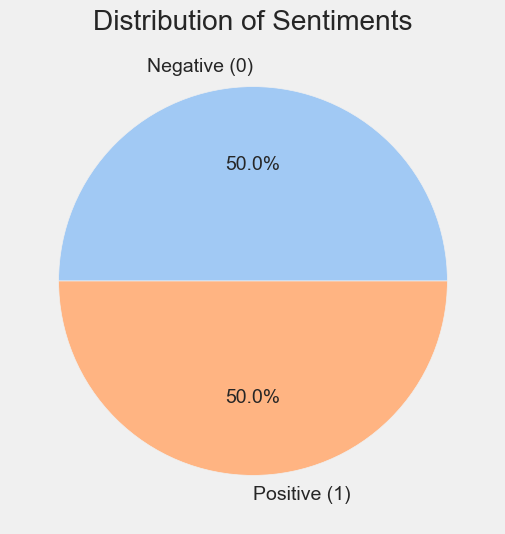

In [5]:
df['target'] = df['target'].replace(4, 1)

target_counts = df['target'].value_counts()
print(f"Negative tweets (0): {target_counts[0]}")
print(f"Positive tweets (1): {target_counts[1]}")

plt.figure(figsize=(8, 6))
target_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Negative (0)', 'Positive (1)'], colors=sns.color_palette('pastel'))
plt.title('Distribution of Sentiments')
plt.ylabel('')
plt.show()

#### 2.3.1 Statistical Test for Class Balance

We will perform a chi-square test to statistically verify that the dataset is balanced between positive and negative sentiments.

In [6]:
from scipy.stats import chisquare

# Expected frequencies for balanced classes
expected_freq = [len(df) / 2, len(df) / 2]
observed_freq = df['target'].value_counts().sort_index().values

chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)

print("Chi-Square Test for Class Balance:")
print(f"Chi-Square Statistic: {chi2_stat:.6f}")
print(f"P-value: {p_value:.6f}")
print(f"\nObserved frequencies: Negative={observed_freq[0]}, Positive={observed_freq[1]}")
print(f"Expected frequencies: {expected_freq[0]:.0f} each")
print(f"\nInterpretation: {'Dataset is balanced (p > 0.05)' if p_value > 0.05 else 'Dataset is imbalanced (p < 0.05)'}")

Chi-Square Test for Class Balance:
Chi-Square Statistic: 0.000000
P-value: 1.000000

Observed frequencies: Negative=800000, Positive=800000
Expected frequencies: 800000 each

Interpretation: Dataset is balanced (p > 0.05)

Chi-Square Statistic: 0.000000
P-value: 1.000000

Observed frequencies: Negative=800000, Positive=800000
Expected frequencies: 800000 each

Interpretation: Dataset is balanced (p > 0.05)


#### 2.4 Text Length Analysis

We will analyze the length of the tweets to understand the typical character count and see if there's a difference between positive and negative tweets.

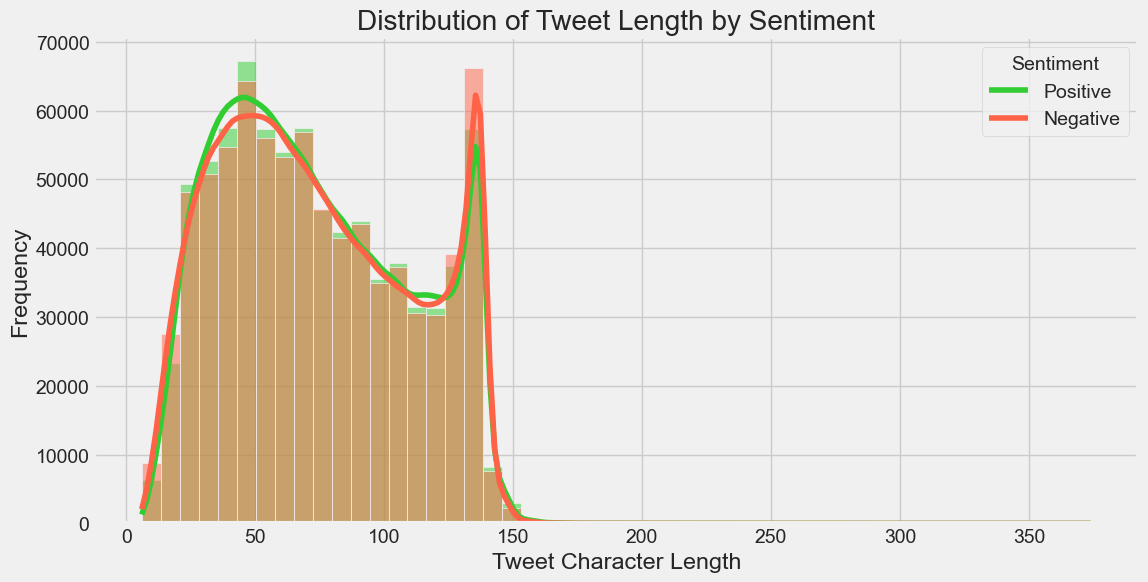

In [7]:
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='target', bins=50, kde=True, palette=['#FF6347', '#32CD32'])
plt.title('Distribution of Tweet Length by Sentiment')
plt.xlabel('Tweet Character Length')
plt.ylabel('Frequency')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])
plt.show()

#### 2.4.1 Statistical Test for Text Length Differences

We will perform a Mann-Whitney U test to determine if there's a statistically significant difference in text length between positive and negative tweets.

In [8]:
from scipy.stats import mannwhitneyu

negative_lengths = df[df['target'] == 0]['text_length']
positive_lengths = df[df['target'] == 1]['text_length']

stat, p_value = mannwhitneyu(negative_lengths, positive_lengths, alternative='two-sided')

print("Mann-Whitney U Test for Text Length:")
print(f"U Statistic: {stat:.2f}")
print(f"P-value: {p_value:.6f}")
print(f"\nMean text length - Negative: {negative_lengths.mean():.2f}")
print(f"Mean text length - Positive: {positive_lengths.mean():.2f}")
print(f"\nInterpretation: {'No significant difference (p > 0.05)' if p_value > 0.05 else 'Significant difference exists (p < 0.05)'}")

Mann-Whitney U Test for Text Length:
U Statistic: 321985552473.50
P-value: 0.000000

Mean text length - Negative: 74.30
Mean text length - Positive: 73.88

Interpretation: Significant difference exists (p < 0.05)


#### 2.5 Word Count Analysis

Similarly, let's analyze the number of words per tweet.

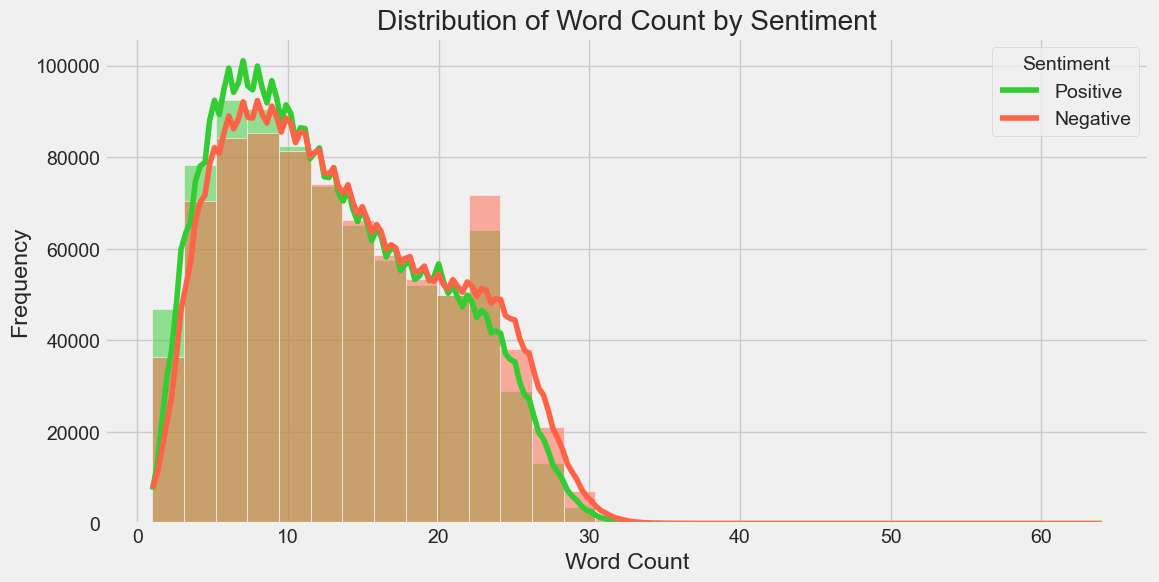

In [9]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='target', bins=30, kde=True, palette=['#FF6347', '#32CD32'])
plt.title('Distribution of Word Count by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])
plt.show()

#### 2.6 Most Common Words & Word Clouds

To understand the topics, we will find the most common words in both positive and negative tweets. We will first define a function to clean the text and then generate word clouds for a visual representation.

/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_32513/3202243383.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=neg_df, ax=axes[0], palette='Reds_d')
/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_32513/3202243383.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=pos_df, ax=axes[1], palette='Greens_d')


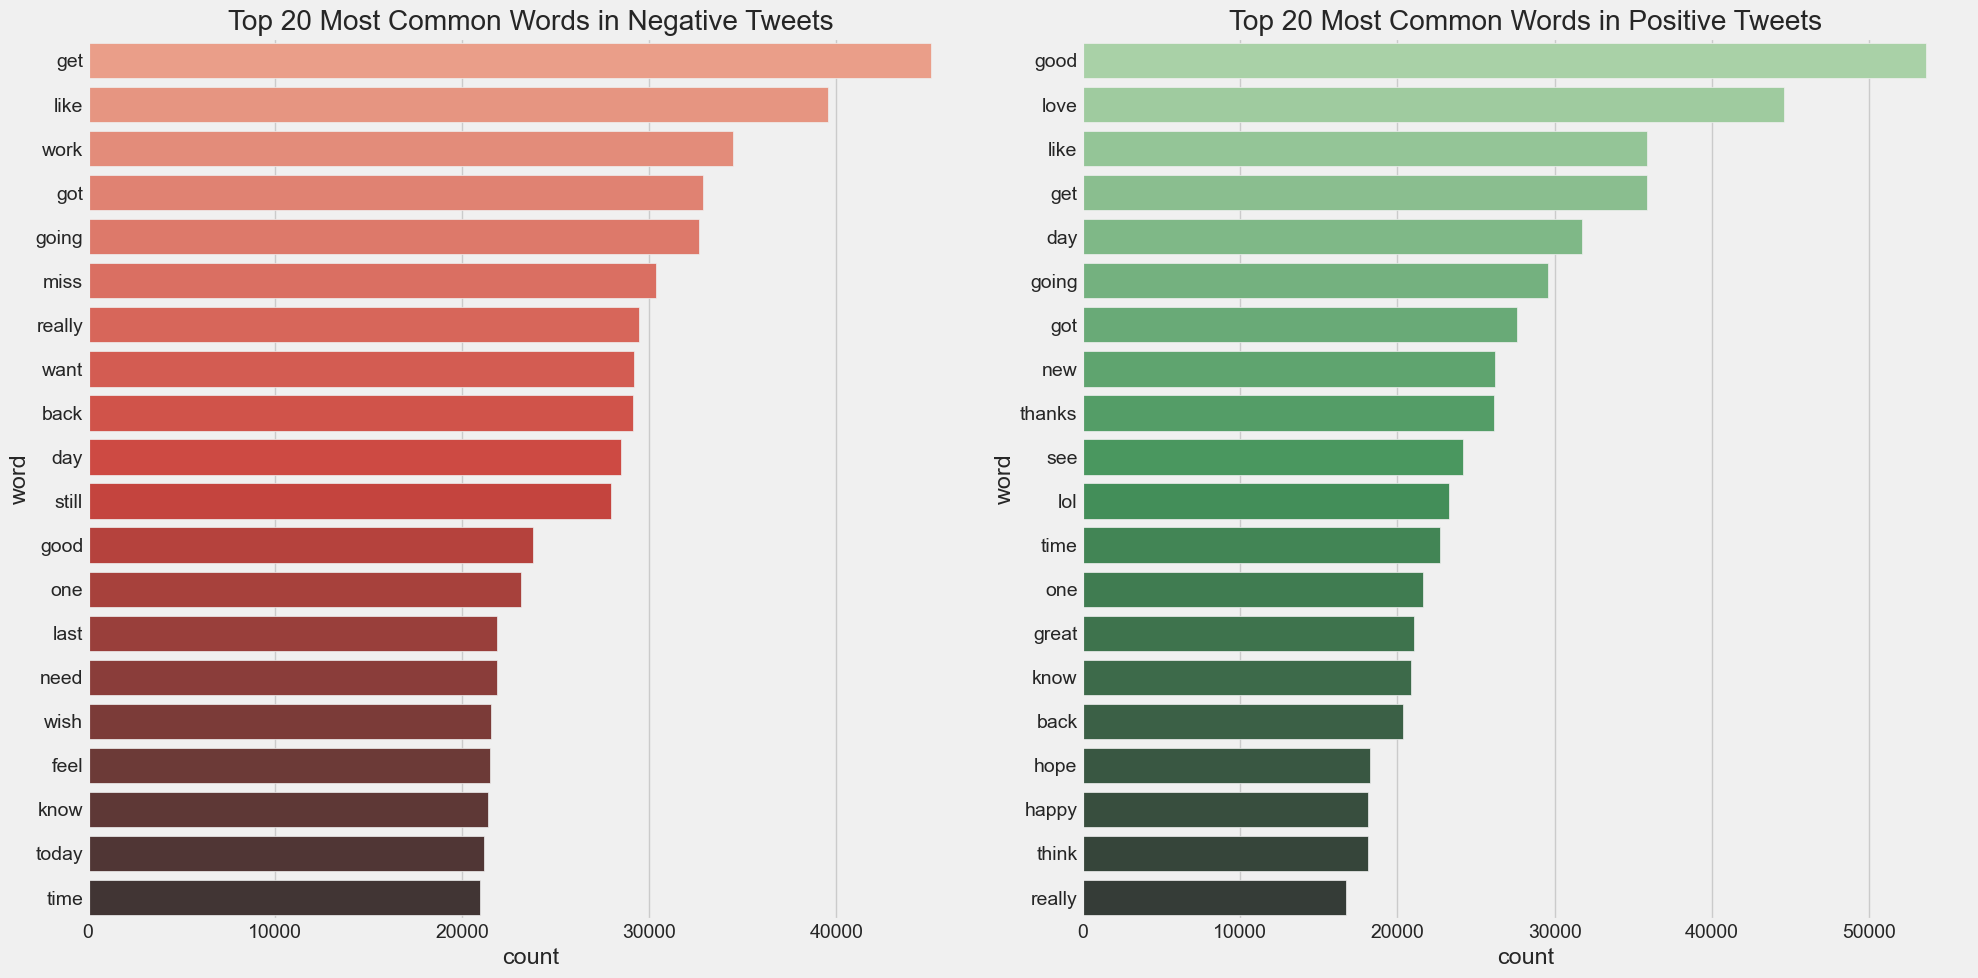

In [10]:
stop_words = set(stopwords.words('english'))

def get_corpus(target):
    corpus = []
    for text in df[df['target']==target]['text'].str.split():
        for word in text:
            corpus.append(word)
    return corpus

def get_most_common_words(corpus, n=20):
    # Clean the corpus
    cleaned_words = []
    for word in corpus:
        word = word.lower()
        if word not in stop_words and word.isalpha() and len(word) > 2:
            cleaned_words.append(word)
    
    word_counts = Counter(cleaned_words)
    return word_counts.most_common(n)

# Get most common words for negative and positive tweets
negative_corpus = get_corpus(0)
positive_corpus = get_corpus(1)

most_common_negative = get_most_common_words(negative_corpus)
most_common_positive = get_most_common_words(positive_corpus)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

neg_df = pd.DataFrame(most_common_negative, columns=['word', 'count'])
sns.barplot(x='count', y='word', data=neg_df, ax=axes[0], palette='Reds_d')
axes[0].set_title('Top 20 Most Common Words in Negative Tweets')

pos_df = pd.DataFrame(most_common_positive, columns=['word', 'count'])
sns.barplot(x='count', y='word', data=pos_df, ax=axes[1], palette='Greens_d')
axes[1].set_title('Top 20 Most Common Words in Positive Tweets')

plt.tight_layout()
plt.show()

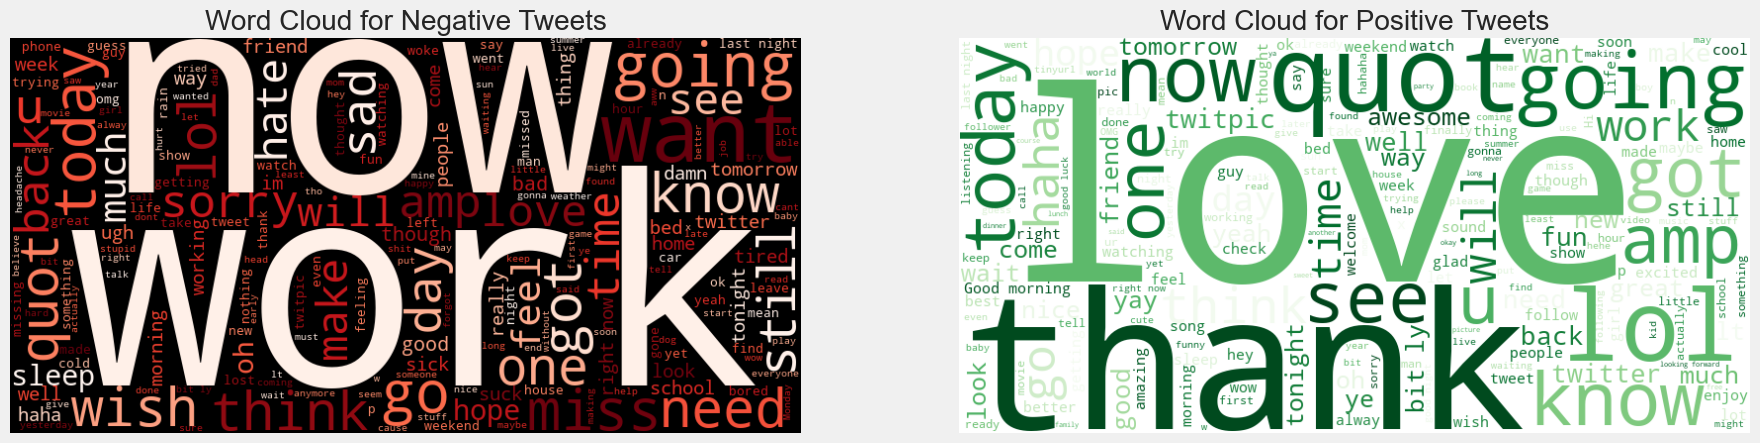

In [11]:
# Generate Word Clouds
negative_text = ' '.join(df[df['target']==0]['text'])
positive_text = ' '.join(df[df['target']==1]['text'])

wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wordcloud_neg, interpolation='bilinear')
axes[0].set_title('Word Cloud for Negative Tweets')
axes[0].axis('off')

axes[1].imshow(wordcloud_pos, interpolation='bilinear')
axes[1].set_title('Word Cloud for Positive Tweets')
axes[1].axis('off')

plt.show()

#### 2.6.1 Temporal Analysis of Tweet Patterns

We will analyze the temporal patterns in the dataset by examining the distribution of tweets over time and by day of week.

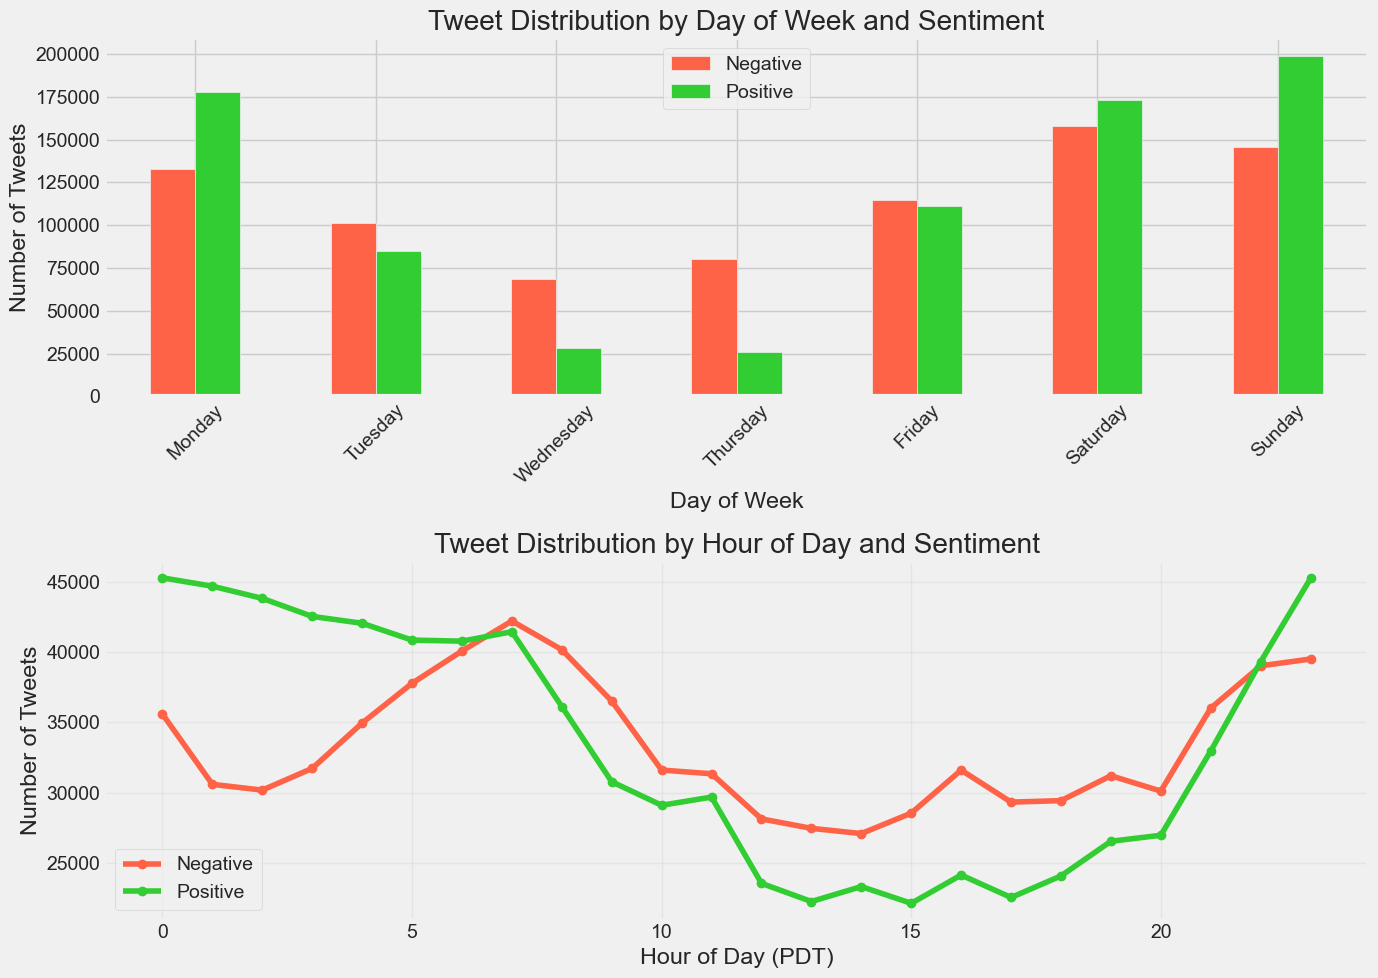


Chi-Square Test for Temporal Independence:
Chi-Square Statistic: 61488.49
P-value: 0.000000
Degrees of Freedom: 6

Interpretation: Sentiment varies by day of week (p < 0.05)


In [12]:
# Parse dates and extract temporal features
df['datetime'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y', errors='coerce')
df['day_of_week'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour

# Analyze tweets by day of week
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Day of week distribution by sentiment
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_sentiment = df.groupby(['day_of_week', 'target']).size().unstack(fill_value=0)
day_sentiment = day_sentiment.reindex(day_order)

day_sentiment.plot(kind='bar', ax=axes[0], color=['#FF6347', '#32CD32'])
axes[0].set_title('Tweet Distribution by Day of Week and Sentiment')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Tweets')
axes[0].legend(['Negative', 'Positive'])
axes[0].set_xticklabels(day_order, rotation=45)

# Hour of day distribution by sentiment
hour_sentiment = df.groupby(['hour', 'target']).size().unstack(fill_value=0)
hour_sentiment.plot(kind='line', ax=axes[1], color=['#FF6347', '#32CD32'], marker='o')
axes[1].set_title('Tweet Distribution by Hour of Day and Sentiment')
axes[1].set_xlabel('Hour of Day (PDT)')
axes[1].set_ylabel('Number of Tweets')
axes[1].legend(['Negative', 'Positive'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test: Chi-square test for day of week distribution
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['day_of_week'], df['target'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test for Temporal Independence:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of Freedom: {dof}")
print(f"\nInterpretation: {'Sentiment is independent of day of week (p > 0.05)' if p_value > 0.05 else 'Sentiment varies by day of week (p < 0.05)'}")

#### 2.7 Summary of Data Understanding

- **Dataset:** The dataset contains 1.6 million tweets and is perfectly balanced between positive (1) and negative (0) sentiments.
- **No Missing Data:** There are no missing values, which simplifies the preprocessing phase.
- **Text Characteristics:** Tweets are generally short, with most having between 40 and 140 characters. The distribution of text length and word count is similar for both positive and negative tweets.
- **Common Words:** Word frequency analysis and word clouds reveal distinct vocabularies for each sentiment. Negative tweets frequently contain words like 'sad', 'miss', 'work', and 'hate', while positive tweets often include 'love', 'good', 'day', and 'thanks'.
- **Next Steps:** The data is now understood well enough to proceed to the Data Preparation phase, where we will perform more rigorous cleaning and feature engineering to prepare it for the model.